In [47]:
import sys
sys.path.append('../../../astro_tools')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
# from tqdm import tqdm
from astropy.wcs import wcs
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import ImageGrid
from reproject import reproject_interp
from astropy import units as u
from matplotlib.lines import Line2D
# from astropy.visualization.wcsaxes import add_beam, add_scalebar
from spectral_cube import SpectralCube
import cmasher as cmr

from convolution import gauss_2d_kernel
from astropy.convolution import Gaussian2DKernel, Box2DKernel, convolve, interpolate_replace_nans

# set up the plot
plt.rcParams['text.usetex'] = False
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.5
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["font.family"] = "courier new"
plt.rcParams["font.style"] = "normal"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.weight"] = 'bold'

import warnings
warnings.filterwarnings('ignore')

In [48]:
def get_offset(dat, w):
    
    center_pix = w.pixel_to_world(dat.shape[1]//2, dat.shape[0]//2)
    
    ra_hr = center_pix.ra.hms[0]
    ra_min = center_pix.ra.hms[1]
    ra_sec = center_pix.ra.hms[2]
    ra_hms = '%s$^{h}$%s$^{m}$%s$^{s}$' % (int(ra_hr), int(ra_min), np.round(ra_sec,2))
    
    dec_deg = center_pix.dec.dms[0]
    dec_min = center_pix.dec.dms[1]
    dec_sec = center_pix.dec.dms[2]
    dec_dms = "%s$^{o}$%s'%s''" % (int(dec_deg), int(np.abs(dec_min)), np.round(np.abs(dec_sec),2))

    return(ra_hms, dec_dms)

def make_big_plot(axNums, outb_dat, outr_dat, disk_dat, vmin, vmax, 
                  titles, line_label, cbar_label, cmap_name):
        
    cmap = cmr.get_sub_cmap(cmap_name, 0.1, 0.90)
    
    # BLUESHIFTED OUTFLOW
    im = axNums[0].imshow(outb_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    axNums[0].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[0].set_facecolor('black')
    axNums[0].set_yticks([-40, -20, 0, 20, 40])
    
    # add label that this is the SE side of the outflow
    at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[0].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[0].add_artist(at)
      
    # add a title to the subplot
    if titles == True:
        axNums[0].set_title('Outflow B', fontsize=26)

    # REDSHIFTED OUTFLOW
    im = axNums[1].imshow(outr_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    axNums[1].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[1].set_facecolor('black')
    
    # add label that this is the SE side of the outflow
    at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[1].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[1].add_artist(at)
        
    if titles == True:
        axNums[1].set_title('Outflow R', fontsize=26)

    # DISK
    im = axNums[2].imshow(disk_dat, origin='lower', cmap=cmap,vmin=vmin,vmax=vmax,extent=extent)
    axNums[2].tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=20, length=5, color='white')
    axNums[2].set_facecolor('black')
    
    # add label that this is the SE side of the outflow
    at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axNums[2].add_artist(at)
    
    # optional label for which line we are looking at
    if line_label != None:
        at = AnchoredText(line_label, prop=Afont, frameon=False, loc='lower left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        axNums[2].add_artist(at)
        
    if titles == True:
        axNums[2].set_title('Disk', fontsize=26)

    cax = axNums[2].inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                                 # [x0, y0, width, height] where x0, y0 = lower left corner
    bar = fig.colorbar(im, ax=axNums[2], cax=cax)
    bar.set_label(cbar_label, fontsize=20)
    bar.ax.tick_params(width=2.5, labelsize=18, length=7, direction='in')

    # plt.savefig('../../ngc253/muse/visuals/niib_ha_amp.png',bbox_inches='tight', dpi=200)
    
    return

Set variables.

In [70]:
chan_width = 1.25 # Angstrom
num_obs = 150
free_params1 = 6
free_params2 = 12
free_params3 = 18
savepath1 = '../../../ngc253/muse/2024July2/fits1_total/'
savepath2 = '../../../ngc253/muse/2024July2/fits2_total/'
savepath3 = '../../../ngc253/muse/2024July2/fits3_total/'
infile1 = '%sfits1_reordered.txt' % savepath1
infile2 = '%sfits2_reordered.txt' % savepath2
infile3 = '%sfits3_reordered.txt' % savepath3
ERRinfile1 = '%sfits1_err_reordered.txt' % savepath1
ERRinfile2 = '%sfits2_err_reordered.txt' % savepath2
ERRinfile3 = '%sfits3_err_reordered.txt' % savepath3

fits1 = pd.read_csv(infile1)
fits2 = pd.read_csv(infile2)
fits3 = pd.read_csv(infile3)
ERRfits1 = pd.read_csv(ERRinfile1)
ERRfits2 = pd.read_csv(ERRinfile2)
ERRfits3 = pd.read_csv(ERRinfile3)

# get info of original data
og = '../../../ngc253/muse/data/NGC253_MUSE_SE_Fitted.fits'
hdu = fits.open(og)[1]
og_data = hdu.data
y, x = og_data[1].shape
print(y,x)
w = wcs.WCS(hdu.header, naxis=2).celestial

# open the BIC_PHYS test fits file
which_model_infile = '../../../ngc253/muse/2024July2/BIC_test/BIC_RATIO_1p5.fits'
hdu_BIC = fits.open(which_model_infile)
which_model = hdu_BIC[0].data

# open the disk velocity model
disk_map_infile = '../../../ngc253/muse/data/ngc253_se_halpha_vel_model_smooth_replaceCO_andsmooth.fits'
hdu_Ha = fits.open(disk_map_infile)
disk_map = hdu_Ha[0].data
print(disk_map.shape)

# disk_map_infile = '../../ngc253/data/Krieger19_CO_velocity_ngc253_vsys_barycentric.fits'
# hdu_CO = fits.open(disk_map_infile)
# disk_map = hdu_CO[0].data
# print(disk_map.shape)

436 437
(436, 437)


Get everything into numpy arrays! Working with NIIb.

In [72]:
BIC_map1 = np.full((y,x), np.nan)
BIC_map2 = np.full((y,x), np.nan)
BIC_map3 = np.full((y,x), np.nan)
redchisq_map1 = np.full((y,x), np.nan)
redchisq_map2 = np.full((y,x), np.nan)
redchisq_map3 = np.full((y,x), np.nan)
amp_map1 = np.full((y,x), np.nan)
amp_map2_b = np.full((y,x), np.nan)
amp_map2_r = np.full((y,x), np.nan)
amp_map3_b = np.full((y,x), np.nan)
amp_map3_0 = np.full((y,x), np.nan)
amp_map3_r = np.full((y,x), np.nan)
vel_map1 = np.full((y,x), np.nan)
vel_map2_b = np.full((y,x), np.nan)
vel_map2_r = np.full((y,x), np.nan)
vel_map3_b = np.full((y,x), np.nan)
vel_map3_0 = np.full((y,x), np.nan)
vel_map3_r = np.full((y,x), np.nan)
sig_map1 = np.full((y,x), np.nan)
sig_map2_b = np.full((y,x), np.nan)
sig_map2_r = np.full((y,x), np.nan)
sig_map3_b = np.full((y,x), np.nan)
sig_map3_0 = np.full((y,x), np.nan)
sig_map3_r = np.full((y,x), np.nan)
amp_err1 = np.full((y,x), np.nan)
amp_err2_b = np.full((y,x), np.nan)
amp_err2_r = np.full((y,x), np.nan)
amp_err3_b = np.full((y,x), np.nan)
amp_err3_0 = np.full((y,x), np.nan)
amp_err3_r = np.full((y,x), np.nan)

# make maps of the BICs, velocities, and FWHMs
for index, row in fits1.iterrows():
    redchisq_map1[int(row['Y']), int(row['X'])] = row['RedChiSq']
    BIC_map1[int(row['Y']), int(row['X'])] = row['BIC']
    amp_map1[int(row['Y']), int(row['X'])] = row['Amp3'] #row['Vel2']
    vel_map1[int(row['Y']), int(row['X'])] = row['Vel3'] #row['Vel2']
    sig_map1[int(row['Y']), int(row['X'])] = row['SigVel3']
    
    # channel width * rms * sqrt(number of channels)
    amp_err1[int(row['Y']), int(row['X'])] = chan_width * row['rms']*np.sqrt(row['Sig3']/chan_width) 
    
for index, row in fits2.iterrows():
    redchisq_map2[int(row['Y']), int(row['X'])] = row['RedChiSq']
    BIC_map2[int(row['Y']), int(row['X'])] = row['BIC']
    amp_map2_b[int(row['Y']), int(row['X'])] = row['Amp5'] #row['Vel3']
    amp_map2_r[int(row['Y']), int(row['X'])] = row['Amp6'] #row['Vel4']
    vel_map2_b[int(row['Y']), int(row['X'])] = row['Vel5'] #row['Vel3']
    vel_map2_r[int(row['Y']), int(row['X'])] = row['Vel6'] #row['Vel4']
    sig_map2_b[int(row['Y']), int(row['X'])] = row['SigVel5']#row['SigVel3']
    sig_map2_r[int(row['Y']), int(row['X'])] = row['SigVel6']#row['SigVel4']
    
    # channel width * rms * sqrt(number of channels)
    amp_err2_b[int(row['Y']), int(row['X'])] = chan_width * row['rms']*np.sqrt(row['Sig5']/chan_width) 
    amp_err2_r[int(row['Y']), int(row['X'])] = chan_width * row['rms']*np.sqrt(row['Sig6']/chan_width) 
    
for index, row in fits3.iterrows():
    redchisq_map3[int(row['Y']), int(row['X'])] = row['RedChiSq']
    BIC_map3[int(row['Y']), int(row['X'])] = row['BIC']
    amp_map3_b[int(row['Y']), int(row['X'])] = row['Amp7'] #row['Vel4']
    amp_map3_0[int(row['Y']), int(row['X'])] = row['Amp8']#row['Vel5']
    amp_map3_r[int(row['Y']), int(row['X'])] = row['Amp9']#row['Vel6']
    vel_map3_b[int(row['Y']), int(row['X'])] = row['Vel7'] #row['Vel4']
    vel_map3_0[int(row['Y']), int(row['X'])] = row['Vel8']#row['Vel5']
    vel_map3_r[int(row['Y']), int(row['X'])] = row['Vel9']#row['Vel6']
    sig_map3_b[int(row['Y']), int(row['X'])] = row['SigVel7']#row['SigVel4']
    sig_map3_0[int(row['Y']), int(row['X'])] = row['SigVel8']#row['SigVel5']
    sig_map3_r[int(row['Y']), int(row['X'])] = row['SigVel9']#row['SigVel6']
    
    # channel width * rms * sqrt(number of channels)
    amp_err3_b[int(row['Y']), int(row['X'])] = chan_width * row['rms']*np.sqrt(row['Sig7']/chan_width)
    amp_err3_0[int(row['Y']), int(row['X'])] = chan_width * row['rms']*np.sqrt(row['Sig8']/chan_width) 
    amp_err3_r[int(row['Y']), int(row['X'])] = chan_width * row['rms']*np.sqrt(row['Sig9']/chan_width) 
    

# blank out edges
# BIC_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# BIC_map2[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# BIC_map3[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# redchisq_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# redchisq_map2[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# redchisq_map3[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# amp_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# amp_map2_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# amp_map2_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# amp_map3_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# amp_map3_0[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# amp_map3_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# vel_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# vel_map2_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# vel_map2_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# vel_map3_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# vel_map3_0[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# vel_map3_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# sig_map1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# sig_map2_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# sig_map2_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# sig_map3_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# sig_map3_0[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# sig_map3_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# amp_err1[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# amp_err2_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# amp_err2_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# amp_err3_b[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# amp_err3_0[np.isnan(og_data[1])] = np.nan # [0] has some nans within
# amp_err3_r[np.isnan(og_data[1])] = np.nan # [0] has some nans within

In [54]:
fits1

,X,Y,RedChiSq,Amp1,Amp2,Amp3,Amp4,Amp5,Wvl1,Wvl2,...,Vel3,Vel4,Vel5,SigVel1,SigVel2,SigVel3,SigVel4,SigVel5,rms,BIC
0,2,182,0.842,58.846,231.253,176.538,114.323,68.057,6552.863,6567.625,...,-22.492515,-22.481392,-22.462235,62.950039,62.808548,62.611549,61.371798,61.240681,26.774539,151.311812
1,2,183,1.648,78.984,281.130,236.953,97.703,63.276,6553.162,6567.925,...,-8.776303,-8.768770,-8.778910,62.262811,62.122865,61.928016,60.701800,60.572115,15.025445,267.375812
2,2,184,1.949,71.684,234.244,215.051,57.815,85.964,6552.894,6567.656,...,-21.079882,-21.052063,-21.080531,59.788792,59.654407,59.467301,58.289808,58.165276,18.225265,310.719812
3,3,181,1.121,67.602,316.213,202.805,91.647,70.421,6552.707,6567.469,...,-29.601250,-29.628035,-29.638181,57.085697,56.957388,56.778741,55.654484,55.535581,24.885227,191.487812
4,3,182,1.277,51.586,248.858,154.758,72.426,59.625,6553.050,6567.812,...,-13.925579,-13.905420,-13.904585,68.264598,68.111162,67.897531,66.553114,66.410928,18.153976,213.951812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95171,433,250,0.560,31.671,106.649,95.014,66.817,58.907,6553.555,6568.318,...,9.177810,9.187171,9.183241,113.575797,113.320517,112.965087,110.728302,110.491738,37.372874,110.703812
95172,434,248,1.566,37.471,126.918,112.414,32.018,49.413,6553.691,6568.455,...,15.420737,15.440483,15.423194,105.833034,105.595157,105.263957,103.179661,102.959223,21.208620,255.567812
95173,434,249,1.058,44.601,156.218,133.803,78.744,33.034,6553.326,6568.089,...,-1.257449,-1.264795,-1.290966,89.385390,89.184481,88.904754,87.144380,86.958201,31.898575,182.415812
95174,434,250,1.003,31.416,127.901,94.248,63.231,19.134,6553.216,6567.978,...,-6.315587,-6.312112,-6.327499,115.820741,115.560414,115.197959,112.916962,112.675722,33.557291,174.495812


### Split based on velocities.

In [73]:
# blueshifted 2 component model is disk
mask2_b = ((np.abs(vel_map2_b - disk_map) < np.abs(vel_map2_r - disk_map)))

# redshifted 2 component model is disk
mask2_r = ((np.abs(vel_map2_r - disk_map) < np.abs(vel_map2_b - disk_map)))

# blueshifted 3 component model is disk
mask3_b = ((np.abs(vel_map3_b - disk_map) < np.abs(vel_map3_r - disk_map)) & \
          (np.abs(vel_map3_b - disk_map) < np.abs(vel_map3_0 - disk_map)))

# middle 3 component model is disk
mask3_0 = ((np.abs(vel_map3_0 - disk_map) < np.abs(vel_map3_b - disk_map)) & \
          (np.abs(vel_map3_0 - disk_map) < np.abs(vel_map3_r - disk_map)))

# redshifted 3 component model is disk
mask3_r = ((np.abs(vel_map3_r - disk_map) < np.abs(vel_map3_b - disk_map)) & \
          (np.abs(vel_map3_r - disk_map) < np.abs(vel_map3_0 - disk_map)))

# ================================================================================

#fwhm_mask = (fwhm_map1 > 100.)
print(vel_map3_r[144,133])
print(vel_map3_0[144,133])
print(vel_map3_b[144,133])
print(disk_map[144,133])
print(' ')
print(np.abs(vel_map3_r[144,133] - disk_map[144,133]))
print(np.abs(vel_map3_0[144,133] - disk_map[144,133]))
print(np.abs(vel_map3_b[144,133] - disk_map[144,133]))


151.30693633278133
6.7170936211477965
-328.89721194817685
16.88908670430743
 
134.4178496284739
10.171993083159634
345.7862986524843


In [88]:
# original version without fwhm mask
# DISK
disk_amp = np.empty((y,x))
disk_amp[which_model == 1.] = amp_map1[which_model == 1.]  # assume 1 is disk
# disk_amp[(which_model == 2.) & mask2_b] = amp_map2_b[(which_model == 2.) & mask2_b]
# disk_amp[(which_model == 2.) & mask2_r] = amp_map2_r[(which_model == 2.) & mask2_r]
# disk_amp[(which_model == 3.) & mask3_b] = amp_map3_b[(which_model == 3.) & mask3_b]
# disk_amp[(which_model == 3.) & mask3_0] = amp_map3_0[(which_model == 3.) & mask3_0]
# disk_amp[(which_model == 3.) & mask3_r] = amp_map3_r[(which_model == 3.) & mask3_r]
# disk_amp[np.isnan(og_data[1])] = np.nan

disk_vel = np.empty((y,x))
disk_vel[which_model == 1.] = vel_map1[which_model == 1.]  # assume 1 is disk
print(disk_vel[np.isfinite(disk_vel)])
# disk_vel[(which_model == 2.) & mask2_b] = vel_map2_b[(which_model == 2.) & mask2_b]
# disk_vel[(which_model == 2.) & mask2_r] = vel_map2_r[(which_model == 2.) & mask2_r]
# disk_vel[(which_model == 3.) & mask3_b] = vel_map3_b[(which_model == 3.) & mask3_b]
# disk_vel[(which_model == 3.) & mask3_0] = vel_map3_0[(which_model == 3.) & mask3_0]
# disk_vel[(which_model == 3.) & mask3_r] = vel_map3_r[(which_model == 3.) & mask3_r]
# disk_vel[np.isnan(og_data[1])] = np.nan

disk_sig = np.empty((y,x))
disk_sig[which_model == 1.] = sig_map1[which_model == 1.]  # assume 1 is disk
disk_sig[(which_model == 2.) & mask2_b] = sig_map2_b[(which_model == 2.) & mask2_b]
disk_sig[(which_model == 2.) & mask2_r] = sig_map2_r[(which_model == 2.) & mask2_r]
disk_sig[(which_model == 3.) & mask3_b] = sig_map3_b[(which_model == 3.) & mask3_b]
disk_sig[(which_model == 3.) & mask3_0] = sig_map3_0[(which_model == 3.) & mask3_0]
disk_sig[(which_model == 3.) & mask3_r] = sig_map3_r[(which_model == 3.) & mask3_r]
# disk_sig[np.isnan(og_data[1])] = np.nan

# OUTFLOW B (BLUESHIFTED)
outflow1_amp = np.full((y,x), np.nan)
outflow1_amp[(which_model == 2.) & mask2_r] = amp_map2_b[(which_model == 2.) & mask2_r]
outflow1_amp[(which_model == 3.) & mask3_r] = amp_map3_b[(which_model == 3.) & mask3_r]
outflow1_amp[(which_model == 3.) & mask3_0] = amp_map3_b[(which_model == 3.) & mask3_0]

outflow1_vel = np.full((y,x), np.nan)
outflow1_vel[(which_model == 2.) & mask2_r] = vel_map2_b[(which_model == 2.) & mask2_r]
outflow1_vel[(which_model == 3.) & mask3_r] = vel_map3_b[(which_model == 3.) & mask3_r]
outflow1_vel[(which_model == 3.) & mask3_0] = vel_map3_b[(which_model == 3.) & mask3_0]


outflow1_sig = np.full((y,x), np.nan)
outflow1_sig[(which_model == 2.) & mask2_r] = sig_map2_b[(which_model == 2.) & mask2_r]
outflow1_sig[(which_model == 3.) & mask3_r] = sig_map3_b[(which_model == 3.) & mask3_r]
outflow1_sig[(which_model == 3.) & mask3_0] = sig_map3_b[(which_model == 3.) & mask3_0]

# OUTFLOW R (REDSHIFTED)
outflow2_amp = np.full((y,x), np.nan)
outflow2_amp[(which_model == 2.) & mask2_b] = amp_map2_r[(which_model == 2.) & mask2_b]
outflow2_amp[(which_model == 3.) & mask3_b] = amp_map3_r[(which_model == 3.) & mask3_b]
outflow2_amp[(which_model == 3.) & mask3_0] = amp_map3_r[(which_model == 3.) & mask3_0]

outflow2_vel = np.full((y,x), np.nan)
outflow2_vel[(which_model == 2.) & mask2_b] = vel_map2_r[(which_model == 2.) & mask2_b]
outflow2_vel[(which_model == 3.) & mask3_b] = vel_map3_r[(which_model == 3.) & mask3_b]
outflow2_vel[(which_model == 3.) & mask3_0] = vel_map3_r[(which_model == 3.) & mask3_0]

outflow2_sig = np.full((y,x), np.nan)
outflow2_sig[(which_model == 2.) & mask2_b] = sig_map2_r[(which_model == 2.) & mask2_b]
outflow2_sig[(which_model == 3.) & mask3_b] = sig_map3_r[(which_model == 3.) & mask3_b]
outflow2_sig[(which_model == 3.) & mask3_0] = sig_map3_r[(which_model == 3.) & mask3_0]

# ==========================================================================================

# do also for the amplitude errors
disk_amp_err = np.empty((y,x))
disk_amp_err[which_model == 1.] = amp_err1[which_model == 1.]  # assume 1 is disk
disk_amp_err[(which_model == 2.) & mask2_b] = amp_err2_b[(which_model == 2.) & mask2_b]
disk_amp_err[(which_model == 2.) & mask2_r] = amp_err2_r[(which_model == 2.) & mask2_r]
disk_amp_err[(which_model == 3.) & mask3_b] = amp_err3_b[(which_model == 3.) & mask3_b]
disk_amp_err[(which_model == 3.) & mask3_0] = amp_err3_0[(which_model == 3.) & mask3_0]
disk_amp_err[(which_model == 3.) & mask3_r] = amp_err3_r[(which_model == 3.) & mask3_r]

outflow1_amp_err = np.full((y,x), np.nan)
outflow1_amp_err[(which_model == 2.) & mask2_r] = amp_err2_b[(which_model == 2.) & mask2_r]
outflow1_amp_err[(which_model == 3.) & mask3_r] = amp_err3_b[(which_model == 3.) & mask3_r]
outflow1_amp_err[(which_model == 3.) & mask3_0] = amp_err3_b[(which_model == 3.) & mask3_0]

outflow2_amp_err = np.full((y,x), np.nan)
outflow2_amp_err[(which_model == 2.) & mask2_b] = amp_err2_r[(which_model == 2.) & mask2_b]
outflow2_amp_err[(which_model == 3.) & mask3_b] = amp_err3_r[(which_model == 3.) & mask3_b]
outflow2_amp_err[(which_model == 3.) & mask3_0] = amp_err3_r[(which_model == 3.) & mask3_0]


[0. 0. 0. ... 0. 0. 0.]


In [89]:
# anchored text font
Afont = {
        'family' : 'courier new',
        'color':  'white',
        'size': 22,
        }

Afont_labels = {
        'family' : 'courier new',
        'color':  'white',
        'size': 15,
        }

Afont_labels1 = {
        'family' : 'courier new',
        'color':  'black',
        'size': 15,
        }

# scalebar font
SBfont = {
        'family' : 'courier new',
        'size': 14,
        }

# vmin = -300
# vmax = 300

In [90]:
ra_hms, dec_dms = get_offset(outflow1_vel, w)
pixscale = 0.2  # arcsec
x_lower = -(which_model.shape[1]*pixscale)//2
x_upper = (which_model.shape[1]*pixscale)//2
y_lower = -(which_model.shape[0]*pixscale)//2
y_upper = (which_model.shape[0]*pixscale)//2
extent=[x_lower,x_upper, y_lower,y_upper]

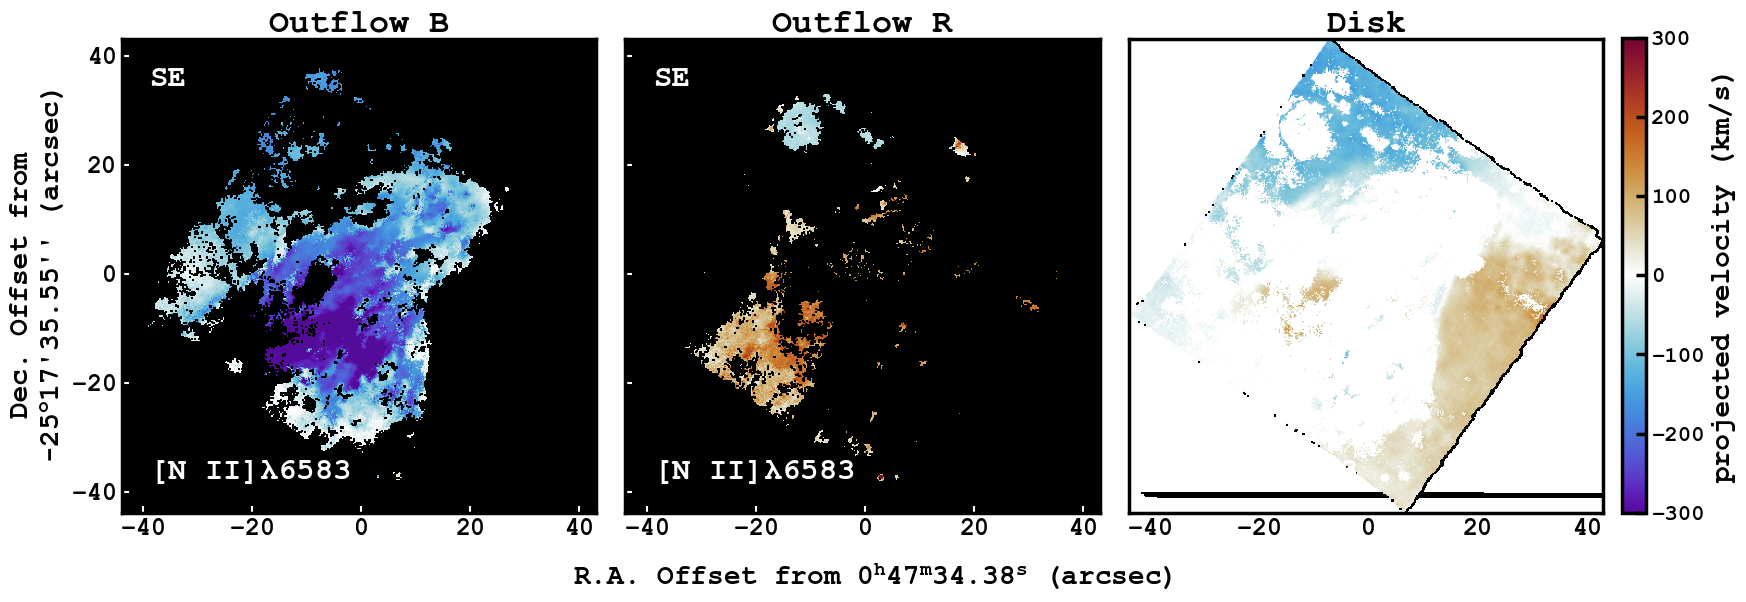

In [91]:
# cmap = 'turbo'
cmap = cmr.get_sub_cmap('cmr.fusion_r', 0.1, 0.90)
# cmap = cmr.fusion_r
# cmap = cmr.redshift
# cmap = cmr.infinity
# cmap = cmr.tropical_r
# cmap = 'rainbow'
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

# BLUESHIFTED OUTFLOW
im = ax1.imshow(outflow1_vel, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=extent)
# ax1.plot(183,212, 's',color='yellow',ms=20)
ax1.set_title('Outflow B', fontsize=24)
ax1.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax1.set_facecolor('black')

at = AnchoredText('[N II]$\lambda6583$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
ax1.set_ylabel('Dec. Offset from \n%s (arcsec)' % dec_dms, fontsize=20)
ax1.set_yticks([-40, -20, 0, 20, 40])


im = ax2.imshow(outflow2_vel, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=extent) #vmin=vmin, vmax=vmax, cmap='rainbow')
ax2.set_title('Outflow R', fontsize=24)
ax2.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax2.set_facecolor('black')

at = AnchoredText('[N II]$\lambda6583$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)


im = ax3.imshow(disk_vel, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=extent)#vmin=vmin, vmax=vmax, origin='lower', cmap='rainbow')
ax3.set_title('Disk', fontsize=24)
ax3.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax3.set_facecolor('black')

at = AnchoredText('[N II]$\lambda 6583$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at)

cax = ax3.inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                             # [x0, y0, width, height] where x0, y0 = lower left corner
bar = fig.colorbar(im, ax=ax3, cax=cax)
bar.set_label('projected velocity (km/s)', fontsize=20)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

fig.supxlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=20, family='courier new', weight='bold', style='normal')
plt.tight_layout()
plt.subplots_adjust(wspace=-0.3, hspace=0)
plt.savefig('../../../ngc253/muse/visuals/2024July2_run/se_vels.png',bbox_inches='tight', dpi=200)
plt.savefig('../../../ngc253/muse/visuals/2024July2_run/se_vels.pdf',bbox_inches='tight', dpi=200)

In [ ]:
cmap = cmr.tropical_r
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

vmin=100
vmax=300

# BLUESHIFTED OUTFLOW
im = ax1.imshow(outflow1_sig * 2.355, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=extent)
ax1.set_title('Outflow B', fontsize=24)
ax1.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax1.set_facecolor('black')

at = AnchoredText('[N II]$\lambda6583$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
ax1.set_ylabel('Dec. Offset from \n%s (arcsec)' % dec_dms, fontsize=20)
ax1.set_yticks([-40, -20, 0, 20, 40])

im = ax2.imshow(outflow2_sig * 2.355, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=extent) #vmin=vmin, vmax=vmax, cmap='rainbow')
ax2.set_title('Outflow R', fontsize=24)
ax2.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax2.set_xlabel('R.A.', fontsize=24)
ax2.set_facecolor('black')

at = AnchoredText('[N II]$\lambda6583$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)

im = ax3.imshow(disk_sig * 2.355, origin='lower', vmin=vmin, vmax=vmax, cmap=cmap, extent=extent)#vmin=vmin, vmax=vmax, origin='lower', cmap='rainbow')
ax3.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='white')
ax3.set_facecolor('black')

at = AnchoredText('[N II]$\lambda 6583$', prop=Afont, frameon=False, loc='lower left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at)
at = AnchoredText('SE', prop=Afont, frameon=False, loc='upper left')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at)
ax3.set_title('Disk', fontsize=24)

cax = ax3.inset_axes([1.04, 0.002, 0.05, 1])  # make another axis for the colorbar 
                                             # [x0, y0, width, height] where x0, y0 = lower left corner
bar = fig.colorbar(im, ax=ax3, cax=cax)
bar.set_label('FWHM (km/s)', fontsize=20)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

fig.supxlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=20, family='courier new', weight='bold', style='normal')
plt.tight_layout()
plt.subplots_adjust(wspace=-0.4, hspace=0)
plt.savefig('../../ngc253/muse/visuals/2024July2_run/se_fwhm.png',bbox_inches='tight', dpi=200)
plt.savefig('../../ngc253/muse/visuals/2024July2_run/se_fwhm.pdf',bbox_inches='tight', dpi=200)

In [ ]:
# let's put both into one big plot!

fig, ((ax1, ax2, ax3),
     (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 12), sharex=True, sharey=True)

# top row
make_big_plot([ax1, ax2, ax3],
              outflow1_vel,
              outflow2_vel,
              disk_vel,
              vmin = -300,
              vmax = 300,
              titles = True,
              line_label = '[N II]$\lambda6583$',
              cbar_label = 'Projected Velocity (km s$^{-1}$)',
              cmap_name = 'cmr.fusion_r')

make_big_plot([ax4, ax5, ax6],
              outflow1_sig * 2.355,
              outflow2_sig * 2.355,
              disk_sig * 2.355,
              vmin = 100,
              vmax = 300,
              titles = False,
              line_label = '[N II]$\lambda6583$',
              cbar_label = 'FWHM (km s$^{-1}$)',
              cmap_name ='cmr.tropical_r')

fig.supxlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=25, family='courier new', weight='bold', style='normal')
fig.supylabel('Dec. Offset from %s (arcsec)' % dec_dms, fontsize=25, family='courier new', weight='bold', style='normal')
plt.tight_layout()
plt.subplots_adjust(wspace=-0.2,hspace=0.05)

plt.savefig('../../ngc253/muse/visuals/2024July2_run/se_projvel_fwhm.png',bbox_inches='tight', dpi=200)
plt.savefig('../../ngc253/muse/visuals/2024July2_run/se_projvel_fwhm.pdf',bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
print(np.median(outflow1_sig[np.isfinite(outflow1_sig)]*2.355))
print(np.mean(outflow1_sig[np.isfinite(outflow1_sig)]*2.355))

Write everything to file to then be used for analysis in other notebooks.

In [ ]:
# make the header
cube = SpectralCube.read('../../ngc253/muse/data/NGC253_MUSE_SE_Fitted.fits', hdu=1)  
hdr = cube.header
hdr['CUNIT3'] = 'km s-1'
hdr['CTYPE3'] = ('VOPT-W2W', 'Optical velocity (linear)')
hdr

In [ ]:
hdul = fits.PrimaryHDU(data=disk_vel, header=hdr)
hdul.writeto('../../ngc253/muse/2024July2/output_maps/ngc253_muse_se_niib_vel_disk.fits',  overwrite=True)
hdul = fits.PrimaryHDU(data=outflow1_vel, header=hdr)
hdul.writeto('../../ngc253/muse/2024July2/output_maps/ngc253_muse_se_niib_vel_outflow_blue.fits',  overwrite=True)
hdul = fits.PrimaryHDU(data=outflow2_vel, header=hdr)
hdul.writeto('../../ngc253/muse/2024July2/output_maps/ngc253_muse_se_niib_vel_outflow_red.fits',  overwrite=True)


hdul = fits.PrimaryHDU(data=disk_amp, header=hdr)
hdul.writeto('../../ngc253/muse/2024July2/output_maps/ngc253_muse_se_niib_amp_disk.fits',  overwrite=True)
hdul = fits.PrimaryHDU(data=outflow1_amp, header=hdr)
hdul.writeto('../../ngc253/muse/2024July2/output_maps/ngc253_muse_se_niib_amp_outflow_blue.fits',  overwrite=True)
hdul = fits.PrimaryHDU(data=outflow2_amp, header=hdr)
hdul.writeto('../../ngc253/muse/2024July2/output_maps/ngc253_muse_se_niib_amp_outflow_red.fits',  overwrite=True)


hdul = fits.PrimaryHDU(data=disk_sig, header=hdr)
hdul.writeto('../../ngc253/muse/2024July2/output_maps/ngc253_muse_se_niib_sig_disk.fits',  overwrite=True)
hdul = fits.PrimaryHDU(data=outflow1_sig, header=hdr)
hdul.writeto('../../ngc253/muse/2024July2/output_maps/ngc253_muse_se_niib_sig_outflow_blue.fits',  overwrite=True)
hdul = fits.PrimaryHDU(data=outflow2_sig, header=hdr)
hdul.writeto('../../ngc253/muse/2024July2/output_maps/ngc253_muse_se_niib_sig_outflow_red.fits',  overwrite=True)


hdul = fits.PrimaryHDU(data=disk_amp_err, header=hdr)
hdul.writeto('../../ngc253/muse/2024July2/output_maps/ngc253_muse_se_niib_amperr_disk.fits',  overwrite=True)
hdul = fits.PrimaryHDU(data=outflow1_amp_err, header=hdr)
hdul.writeto('../../ngc253/muse/2024July2/output_maps/ngc253_muse_se_niib_amperr_outflow_blue.fits',  overwrite=True)
hdul = fits.PrimaryHDU(data=outflow2_amp_err, header=hdr)
hdul.writeto('../../ngc253/muse/2024July2/output_maps/ngc253_muse_se_niib_amperr_outflow_red.fits',  overwrite=True)
